In [1]:
import os
import sys

In [2]:
# Detect if running in Google Colab environment.
# If so, then clone/install SmartStockRL package from GitHub.
# Otherwise, use locally.
try:
    import google.colab
    IN_COLAB = True
    print('IN COLAB')

    # Clone or update repo.
    repo = "smart-stock-rl"
    repo_url = f"https://github.com/zanderman/{repo}.git"
    repo_path = f"/content/{repo}"
    repo_branch = "develop"
    ![ -d $repo_path ] && git -C $repo_path pull || git clone --branch $repo_branch $repo_url
    # !git clone --branch $repo_branch $repo_url

    # Install repo to ensure dependencies are resolved.
    !pip install --upgrade $repo_path

    # Add package location to path.
    sys.path.insert(0, repo_path)

    # Set dataset root path.
    dataset_root = '~/dataset'

except:
    IN_COLAB = False
    dataset_root = '~/Desktop'
    print('NOT IN COLAB')

# Import package.
import smart_stock as ss

NOT IN COLAB


In [3]:
# Install future annotations for <3.7
if sys.version_info < (3,7):
    !pip install future-annotations

In [4]:
# Import other necessary packages after we know that imports are available.
from __future__ import annotations
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

## Dataset

In [5]:
# Request user for Kaggle login if JSON file does not exist.
if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")) and os.environ.get("KAGGLE_USERNAME",None) is None and os.environ.get("KAGGLE_USERNAME",None) is None:
    import json
    import getpass
    entry = getpass.getpass(prompt="Kaggle Username or JSON blob: ")
    try:
        blob = json.loads(entry)
        os.environ["KAGGLE_USERNAME"] = blob['username']
        os.environ["KAGGLE_KEY"] = blob['key']
    except:    
        api_key = getpass.getpass(prompt="Kaggle API KEY: ")
        os.environ["KAGGLE_USERNAME"] = entry
        os.environ["KAGGLE_KEY"] = api_key

    # In Google Colab preserve the login auth across environment restarts.
    if IN_COLAB:
        !mkdir -p ~/.kaggle/
        with open(os.path.expanduser("~/.kaggle/kaggle.json"), 'w') as f:
            json.dump({'username':os.environ["KAGGLE_USERNAME"], 'key':os.environ["KAGGLE_KEY"]}, f)

In [6]:
# Prepare dataset.
stocks = ['aapl', 'nvda', 'dis', 'ko', 'pg']
path = os.path.expanduser(dataset_root)

# This command will download the dataset if it does not exist on the system.
dataset = ss.datasets.HugeStockMarketDataset(path, quiet=False)

## Training Functions

In [7]:
import time
from contextlib import contextmanager

class timecontext:
    """Elapsed time context manager."""
    def __enter__(self):
        self.seconds = time.time()
        return self
    
    def __exit__(self, type, value, traceback):
        self.seconds = time.time() - self.seconds

@contextmanager
def timecontextprint(description='Elapsed time'):
    """Context manager to print elapsed time from call."""
    with timecontext() as t:
        yield t
    print(f"{description}: {t.seconds} seconds")

In [8]:
def train(
    agent,
    env: gym.Env,
    max_episodes: int = 1000,
    **kwargs,
    ) -> tuple[list[float], bool]:
    """Generic agent training method.

    Specific methods should wrap this one and pass agent-specific arguments
    as keyword arguments.
    """
    # List of reward values for plotting.
    rewards = []

    # Boolean solution flag.
    found_soln = False

    # Episode loop.
    for i in range(max_episodes):
        reward = agent.run_episode(env=env, **kwargs)
        rewards.append(reward)
        # if i%100 == 0: print(f'[{i}] {reward}')
        print(f'[{i}] {reward}')

    return rewards, found_soln

In [9]:
def train_QSFM(
    agent: ss.algorithms.qlearning.qsfm.QSFM, 
    env: gym.Env,
    max_episodes: int = 1000,
    max_steps: int = None,
    render: bool = False,
    render_mode: str = None,
    ) -> tuple[list[float], bool]:
    """Train QSFM agent."""
    return train(
        agent=agent,
        env=env,
        max_episodes=max_episodes,
        max_steps=max_steps,
        render=render,
        render_mode=render_mode,
        )

In [10]:
def train_DQN(
    agent: ss.algorithms.deepq.dqn.DQN, 
    env: gym.Env,
    max_episodes: int = 1000,
    max_steps: int = None,
    target_update_freq: int = 10,
    render: bool = False,
    render_mode: str = None,
    ) -> tuple[list[float], bool]:
    """Train DQN agent."""
    return train(
        agent=agent,
        env=env,
        max_episodes=max_episodes,
        max_steps=max_steps, 
        target_update_freq=target_update_freq,
        render=render, 
        render_mode=render_mode,
        )

## Environment

In [11]:
# Make runs reproduceable.
RANDOM_SEED = 0 # Turn off by setting as `None`
if RANDOM_SEED is not None:
    # env.seed(RANDOM_SEED)
    # env.action_space.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)

In [12]:
def build_env(
    stock: str,
    start_balance: float = 10_000,
    max_shares: int = 1,
    start_day: int = None,
    ) -> gym.Env:
    """Create stock environment using specific stock name."""
    env = ss.envs.StockDataEnv(
        df=dataset[stock], 
        start_balance=start_balance, 
        max_shares=max_shares, 
        start_day=start_day,
        name=f'StockDataEnv-{stock.upper()}',
    )

    # Set random seed if one is provided.
    if RANDOM_SEED is not None:
        env.seed(RANDOM_SEED)
        env.action_space.seed(RANDOM_SEED)

    return env


In [13]:
# Create stock environment using specific stock.
env = build_env(
    stock='aapl',
    start_balance=10_000,
    max_shares=10,
    start_day=None,
)

In [14]:
# Set tweakable parameters.
gamma = 0.9 # Discount factor (should be in (0,1)).
alpha = 0.01 # Step size.
epsilon = 0.5 # 0.2 # Epsilon-greedy action selection (should be in (0,1)).
batch_size = 32
memory_capacity = 1000
target_update_freq = 10
render = False
render_mode = 'csv'

# Set PyTorch device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

# Setup DQN policy.
n_actions = len(np.arange(env.action_space.low, env.action_space.high+1))
dims = [
    env.observation_space.shape[0],
    512,
    n_actions
]
policy = ss.algorithms.deepq.policies.FeedForwardLinearPolicy(
    env.action_space,
    env.observation_space,
    epsilon,
    device,
    dims,
    )

# Configure PyTorch optimizer and loss criterion.
optimizer = torch.optim.SGD(policy.policy_net.parameters(), lr=alpha)
criterion = torch.nn.SmoothL1Loss()

# Build agent.
agent = ss.algorithms.deepq.dqn.DQN(
    policy, 
    gamma, 
    alpha, 
    memory_capacity, 
    batch_size,
    optimizer,
    criterion
)

device: cpu


[0] 4.839515243031599
[1] 4.198671443573403
[2] 4.909928900754494
[3] 5.093472193169873
[4] 5.27646224310206
[5] 5.010065447905163
[6] 4.914329476755341
[7] 5.432782134263107
[8] 5.773654948949115
[9] 6.500534854149009
[10] 4.412221649137791
[11] 5.123811596053201
[12] 4.903679237630059
[13] 4.877530130757435
[14] -2.3790559310873505
[15] 5.034797189175151
[16] 5.917856129845859
[17] 4.913784770120117
[18] 7.006337115075439
[19] 4.931213362945214
[20] 4.911041920599018
[21] 4.867654585776336
[22] 4.837874730159456
[23] 4.75914868369955
[24] 4.696788677920267
[25] 4.226374993919308
[26] 5.263709240127355
[27] 3.143690039147259
[28] 6.2998656550144005
[29] 5.639540593841957
[30] 4.768504933465238
[31] 4.8470530013534585
[32] 4.795748621960058
[33] 5.136704561793067
[34] 4.7949047459077825
[35] 2.8021015530945306
[36] 4.785896912167857
[37] 5.12209312081518
[38] 4.824839587291763
[39] 4.859574129846457
[40] 4.828172082439778
[41] 9.669724278774083
[42] 3.949373920067501
[43] 5.88037250195

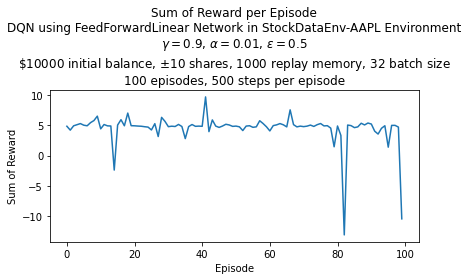

In [15]:
max_episodes = 100 # 1000 # Upper-limit on number of possible episodes.
max_steps = 500 # 50
render = False
render_mode = 'csv'

# Train the agent 
with timecontextprint():
    rewards, found_soln = train_DQN(
        agent,
        env,
        max_episodes, 
        max_steps,
        target_update_freq, 
        render, 
        render_mode,
    )

# Plot the rewards.
plt.figure()
plt.plot(rewards)
plt.title(f"Sum of Reward per Episode\nDQN using FeedForwardLinear Network in {env.name} Environment\n$\gamma={gamma}$, $\\alpha={alpha}$, $\epsilon={epsilon}$\n\${env.start_balance} initial balance, $\pm${env.max_shares} shares, {memory_capacity} replay memory, {batch_size} batch size\n{max_episodes} episodes, {max_steps} steps per episode")
plt.xlabel('Episode')
plt.ylabel('Sum of Reward')
plt.tight_layout()
plt.show()

## Testing

In [16]:
def test(
    agent,
    env: gym.Env,
    ) -> ss.algorithms.deepq.dqn.StateActionTransition:

    # Get initial obseration.
    curr_state = env.reset()

    # Run a single episode.
    transitions: list[ss.algorithms.deepq.dqn.StateActionTransition] = []
    while True:
        curr_state, action, next_state, reward, done = agent.step(
            env,
            curr_state,
            )
        transitions.append(ss.algorithms.deepq.dqn.StateActionTransition(
            curr_state,
            action,
            next_state,
            reward,
        ))

        curr_state = next_state

        if done:
            break

    return ss.algorithms.deepq.dqn.StateActionTransition(*zip(*transitions))

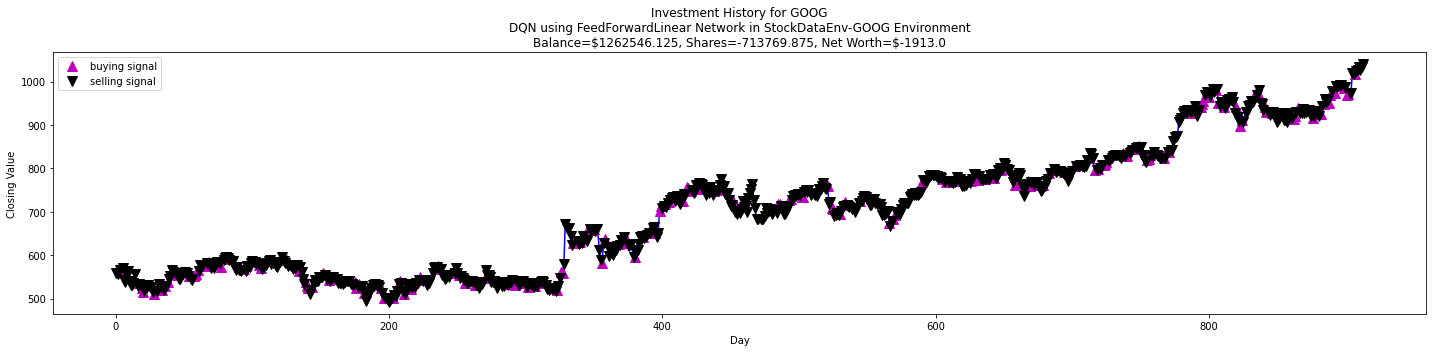

In [17]:
stock_test = 'goog'
env_test = build_env(
    stock=stock_test,
    start_balance=10_000,
    max_shares=10,
    start_day=0,
)
transitions = test(agent, env_test)

# Unpack transition elements.
transition_state = torch.cat(transitions.state)
transition_action = torch.cat(transitions.action)

# Plot investment history.
plt.figure(figsize=(20,5))
plt.plot(transition_state[:,6], color='b')
plt.plot(transition_state[:,6], '^', markersize=10, color='m', label = 'buying signal', markevery=np.where(transition_action>0)[0])
plt.plot(transition_state[:,6], 'v', markersize=10, color='k', label = 'selling signal', markevery=np.where(transition_action<0)[0])
final_balance = transition_state[-1,0]
final_net_worth = transition_state[-1,1]
final_shares = transition_state[-1,2]
plt.title(f"Investment History for {stock_test.upper()}\nDQN using FeedForwardLinear Network in {env_test.name} Environment\nBalance=\${final_balance}, Shares={final_net_worth}, Net Worth=\${final_shares}")
plt.xlabel('Day')
plt.ylabel('Closing Value')
plt.legend()
plt.tight_layout()
plt.show()